# Вторая часть

По первому пути особых успехов добитья не удалось и Юра предложил попробовать сделать очень простой алгоритм.  
Также взять обрезанную часть кадра с рельсом, определить в ней границу.  
И записать трек-маршрут этой границы ,где она сместилась в лево\право и насколько.  
А потом проанализировать эти смещения, и найти характерный паттерн для стыка.

Для работы воспользовались следующими библиотеками:  
* opencv - для чтения видео
* skimage - фильтры для обаботки изображений

In [1]:
#!pip install opencv-python

In [2]:
import os
import time
from typing import Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel, threshold_otsu
from skimage.color import rgb2gray

from IPython.display import clear_output

**Настройки блокнота**

In [3]:
plt.rcParams["figure.figsize"] = [16,9] # Увеличим габариты вывода рисунков

DATA = "../data/CAM0.avi" # путь до файла с видео
OUTPUT_FOLDER = "../data/finded_joint"

LIMITS = (600, 750) # границы рельса, обрезаем по этой рамке
SKIPPED_FRAMES_COUNT = 60  # сколько кадров пропускаем (стыки идут через 60 кадров, поэтому после стыка можно 60 кадров пропустиь)
MAX_DEVIATION = 500 # Максимальное отклонение пути, которое не смотрим при построении трека



# Получаем кадры из видео

С помощью opencv разбивать avi файл на картинки достаточно просто.  
Также сделаем преобразование в серые оттенки, т.к. дальнейшие алгоритмы требуют такого формата картинки.  
Покажем также что картинка это просто np.array, преобразование в серый просто схлопывает 3 измерения цвета в 1 число.

In [4]:
cap = cv2.VideoCapture(DATA)

In [5]:
def show_frame(frame):
    plt.imshow(frame, cmap='gray')
    plt.show()

Цветная картинка это <class 'numpy.ndarray'> (720, 1024, 3)
Серая картинка это <class 'numpy.ndarray'> (720, 1024)


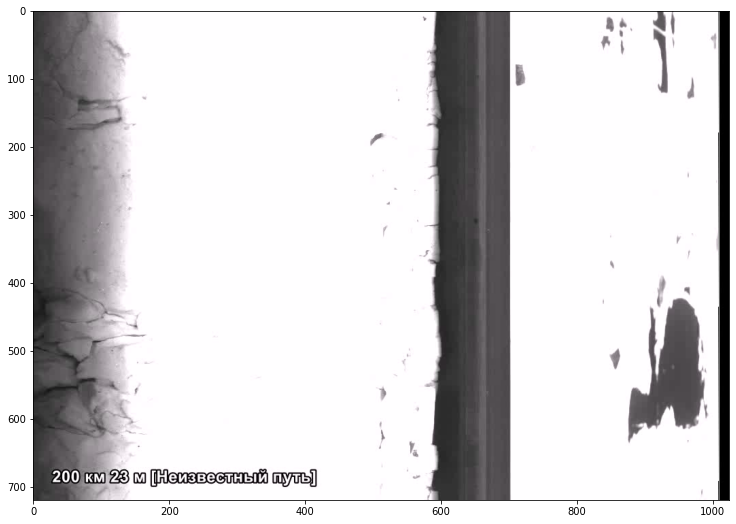

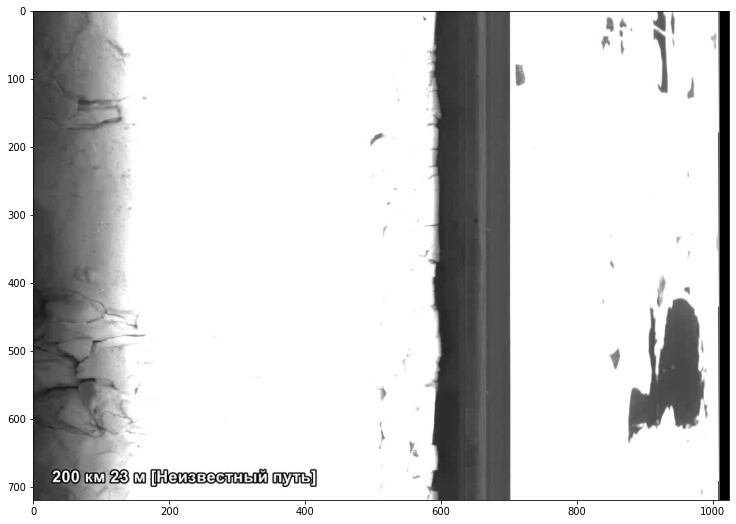

In [6]:
_, rgb_frame = cap.read()
gray_image = rgb2gray(rgb_frame) # преобразуем в серый формат

print(f"Цветная картинка это {type(rgb_frame)} {rgb_frame.shape}")
print(f"Серая картинка это {type(gray_image)} {gray_image.shape}")

show_frame(rgb_frame)
show_frame(gray_image)

# Подготовка видео для работы

Как и в первой части сделаем:
* бинаризацию изображения
* найдем границу изображения

Но сейчас пользуемся фильтрами из библиотеки skimage:
* threshold_otsu
* sobel

**Также делаем допущение, что нам известны точныеграницы в которых находится рельс**

In [7]:
def image_processing(image):
    image = image[:, LIMITS[0]:LIMITS[1]] # обрежем только рельс
    gray_image = rgb2gray(image)
    thresh = threshold_otsu(gray_image)
    binary_mask = gray_image > thresh # выполняем бинаризацию изображения
    binary_image_intermediate = binary_mask.astype(int)
    processed_image = sobel(binary_image_intermediate) # ищем границы изображения
    binary_mask = processed_image == 0
    binary_image = binary_mask.astype(int)
    return gray_image, binary_image, binary_image_intermediate

In [8]:
def image_processing_refacting(image: np.array) -> tuple:
    """
    преобразуем полученное изображение в нужный формат
    обрежем его
    возвращает
    gray_image - серая картинка
    binary_image_intermediate - черно-белая картинка
    binary_image - линия границы черного и белого, 0 - граница, 1 - нет границы
    
    """
    image = image[:, LIMITS[0]:LIMITS[1]] # обрежем только рельс

    gray_image = rgb2gray(image) # преобразуем в серый

    thresh = threshold_otsu(gray_image) 
    binary_mask = gray_image > thresh # выполняем бинаризацию изображения
    binary_image_intermediate = binary_mask.astype(int)

    processed_image = sobel(binary_image_intermediate) # ищем границы изображения
    binary_mask = processed_image == 0
    binary_image = binary_mask.astype(int)

    return gray_image, binary_image, binary_image_intermediate

пример работы

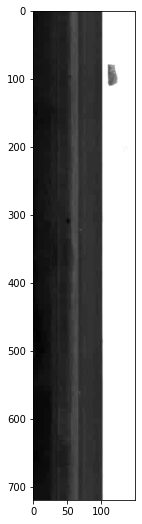

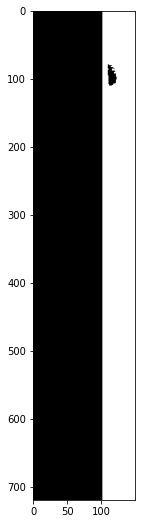

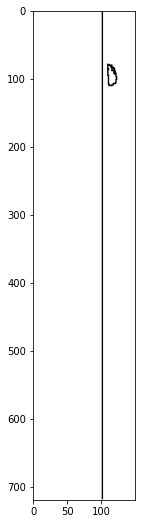

In [9]:
gray_image, binary_image, binary_image_intermediate = image_processing(rgb_frame)
show_frame(gray_image)
show_frame(binary_image_intermediate)
show_frame(binary_image)


# Ищем первую колонку

У нас есть картинка `binary_image` с линией. Фактически это двумерный массив (строки и столбцы), в который 0 соответствует тому что в этом пикселе есть граница (черное), а 1 тому что нет (белое поле).  

Первая задача найти стартовую колонку. Для этого ищем первый 0 в первой строке. Если не находим то ищем во второй и далее.  

Ищем с обратной строны, т.к. если с начала - то часто попадаются ошибки

In [10]:
def find_first_column(binary_image):
    start_column = binary_image.shape[1] - 1
    row = 0
    while binary_image[row, start_column] == 1:
        start_column -= 1
        if start_column == 0:
            # return binary_image.shape[1] - 1
            row += 1
            start_column = binary_image.shape[1] - 1
    return start_column

In [11]:
BORDER_MARKER_AT_POINT = 0  # отметка границы

def find_first_column_refacting(binary_image: np.array) -> int:
    """
    ищем первую колонку в которой стоит BORDER_MARKER_AT_POINT
    это значит что с это колонки мы будем начинать искать нить рельса
    """
    current_row = 0
    current_column = binary_image.shape[1] - 1
    while binary_image[current_row, current_column] != BORDER_MARKER_AT_POINT:
        current_column -= 1
        if current_column == 0:
            current_row += 1
            current_column = binary_image.shape[1]-1
    return current_column

пример работы

In [12]:
print(find_first_column(binary_image))

102


# Ищем вторую и последующие колонки

Пройдемся по каждой строке и если в текущей колонке нет границы (убежала куда-то), то ищем границы влево и вправо от текущей колонки, и сохраняем ее. Такие смещения и выдают нам стык.  
Но бывают и ложные срабатывания поэтому сделаны ряд проверок.
* если нашли смещение рельса, то проверяем что в предудушей или предпредыдушей линии должна быть горизонтальная линия. Функция gen_old отвечает за это - возвращает предыдущую строку в диапазоне смещения.
* если есть смещение и влево и вправо - то берем наименьшее смещение
* если смещение больше параметра MAX_DEVIATION - то не анализируем его
* если смещение относительно среднего значения границы больше, чем для старого значения границы - то оставляем старое значение границы (этот момент немного не понятен мне самому)

In [13]:
def gen_old(old_column, column, binary_image, row):
    c1 = min(old_column, column)
    c2 = max(old_column, column)
    old1 = binary_image[row-1, c1:c2+1]
    try:
        old2 = binary_image[row-2, c1:c2+1]
    except:
        old2 = np.copy(old1)
    old = old1 if np.sum(old1) < np.sum(old2) else old2
    return old

In [14]:
def find_next_column(binary_image, row, column, current_border):
    old_column = column

    # ищем ноль, ближайший к column, слева
    ok_left = True
    new_column_left = column
    k = 0
    while binary_image[row, new_column_left] == 1:
        k += 1
        new_column_left -= 1
        if (k > MAX_DEVIATION) or (new_column_left < 0):
            ok_left = False
            break

    # ищем ноль, ближайший к column, справа
    ok_right = True
    new_column_right = column
    k = 0
    while binary_image[row, new_column_right] == 1:
        k += 1
        new_column_right += 1
        if (k > MAX_DEVIATION) or (new_column_right >= binary_image.shape[1]):
            ok_right = False
            break

    if not ok_right and not ok_left:
        # pass
        # column = None
        return column
    elif ok_left and not ok_right:
        column = new_column_left
    elif ok_right and not ok_left:
        column = new_column_right
    else:
        delta_left = column - new_column_left
        delta_right = new_column_right - column

        old = gen_old(old_column, new_column_left, binary_image, row)
        bad_left = np.sum(old) / len(old) > 0.5

        old = gen_old(old_column, new_column_right, binary_image, row)
        bad_right = np.sum(old) / len(old) > 0.5

        if delta_left <= delta_right:
            if not bad_left:
                column = new_column_left
            else:
                column = new_column_right
        else:
            if not bad_right:
                column = new_column_right
            else:
                column = new_column_left

    old = gen_old(old_column, column, binary_image, row)
    if np.sum(old)/len(old) > 0.5:
        if len(current_border) > 0:
            mean = np.mean(current_border)
            if abs(mean-column) > abs(mean-old_column):
                column = old_column
    return column

пример работы

In [15]:
current_column = find_first_column(binary_image)
border = [current_column]
for i in range(1, binary_image.shape[0]):
    current_column = find_next_column(binary_image, i, current_column, border)
    border.append(current_column)
np.array(border)

array([102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 10

Отрефакторенная версия (писал когда пытался понять алгоритм лучше, может быть не точно также работает)

In [16]:
def get_border_shift(row: np.array, current_column: int, direction: int) -> Optional[int]:
    """
    Из массива значений текущей строки ищет смещение границы в направлении direction(+1, -1)
    """
    cut_row = row[current_column+direction::direction]
    border_position = np.where(cut_row == BORDER_MARKER_AT_POINT)
    if len(border_position[0] > 0):
        border_shift = border_position[0][0]
        if border_shift <= MAX_DEVIATION:
            # +1 потому что обрезали строку с первого элемента, если граница в 0-ом то это смещение в 1 пиксель
            return (border_shift + 1) * direction


def there_is_line_in_previous_row(binary_image: np.array, current_row: int, current_column: int, shift: int) -> bool:
    """
    Если мы нашли смещение линии пути, то в предыдущем кадре должна быть горизонтальная линия.
    Проверяем ее наличие (количество черных точек больше 50%)
    """
    column_min = min(current_column, current_column + shift)
    column_max = max(current_column, current_column + shift)
    old_row = binary_image[current_row-1, column_min:column_max+1]
    if current_row > 2:
        # если строка не первая то смотрим еще строку назад
        # и выбираем ту, где нулей больше (общее значение меньше)
        old_row2 = binary_image[current_row-2, column_min:column_max+1]
        if old_row2.sum() < old_row.sum():
            old_row = old_row2
    return old_row.mean() < 0.5


def find_next_column_refactoring(binary_image: np.array, current_row: int, current_column: int, current_border: list) -> int:
    row = binary_image[current_row]
    if row[current_column] == BORDER_MARKER_AT_POINT:
        return current_column

    shift_left = get_border_shift(row, current_column, -1)
    if shift_left:
        shift_left_ok = there_is_line_in_previous_row(
            binary_image, current_row, current_column, shift_left)
        if not shift_left_ok:
            shift_left = None

    shift_right = get_border_shift(row, current_column, 1)
    if shift_right:
        shift_right_ok = there_is_line_in_previous_row(
            binary_image, current_row, current_column, shift_right)
        if not shift_right_ok:
            shift_right = None

    if not shift_left and not shift_right:
        return current_column
    elif shift_left and not shift_right:
        return current_column+shift_left
    elif shift_right and not shift_left:
        return current_column+shift_right
    else:
        if abs(shift_left) > shift_right:
            return current_column+shift_left
        else:
            return current_column+shift_right

проверим ее работу тоже

In [17]:
current_column = find_first_column(binary_image)
border = [current_column]
for i in range(1, binary_image.shape[0]):
    current_column = find_next_column_refactoring(
        binary_image, i, current_column, border)
    border.append(current_column)
np.array(border)

array([102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102,
       102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 10

# Выведем графики

Служебная процедура.   
Когда нашли стык - выводим различные картинки и графики.  


In [18]:
def plot(image, gray_image, binary_image_intermediate, binary_image, border, delta_border, min_a, max_a, min_index, max_index):
    plt.subplot(1, 6, 1)
    plt.imshow(rgb2gray(image[-50: -20, 24: 155]), cmap='gray')
    plt.subplot(1, 6, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.subplot(1, 6, 3)
    plt.imshow(binary_image_intermediate, cmap='gray')
    plt.subplot(1, 6, 4)
    plt.imshow(binary_image, cmap='gray')
    plt.plot(border, np.arange(binary_image.shape[0]), color="red")
    plt.subplot(1, 6, 5)
    plt.plot(delta_border, np.arange(binary_image.shape[0] - 1))
    plt.plot([min_a, max_a], [min_index, max_index], "ro")
    plt.gca().invert_yaxis()
    plt.show()

Пример работы. Индексы минимума и максимума взяты в этом примере случайно.

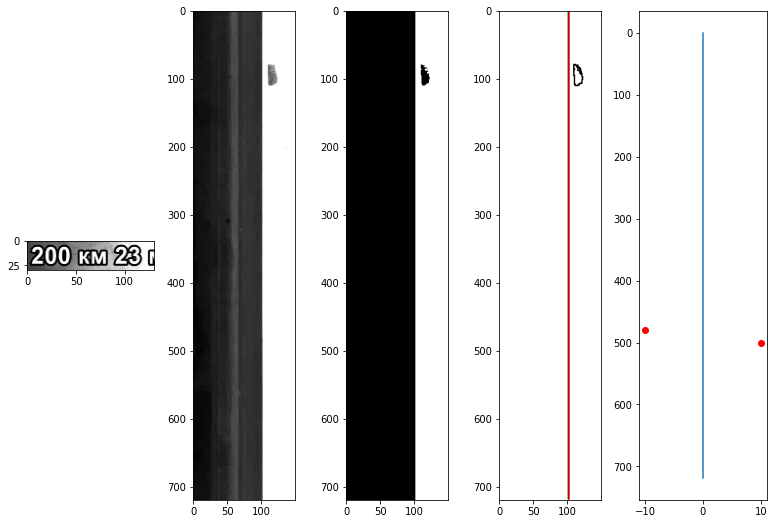

In [19]:
plot(rgb_frame,
     gray_image,
     binary_image_intermediate,
     binary_image,
     border=np.array(border),
     delta_border=np.diff(np.array(border)),
     min_a=-10, 
     max_a=10, 
     min_index=480, 
     max_index=500
     )

# Поиск стыка

Сначала разобьем алгоритм по шагам а потом соберем все воедино.

## Определяем путь рельса за первый проход

In [20]:
gray_image, binary_image, binary_image_intermediate = image_processing(rgb_frame)
        
start_column = find_first_column(binary_image)
row = 0
column = start_column
border = [column, ]
while row < binary_image.shape[0]-1:
    row += 1
    column = find_next_column(binary_image, row, column, border)
    if column is not None:
        border.append(column)
    else:
        border.append(border[-1])
border = np.array(border)


## Убираем все границы, что правее среднего значения рельса + 10

Хардкодинг, но так мы убрали несколько ложных срабатываний

In [21]:
middle = int(np.mean(border))
shift_border = min(middle+10, binary_image.shape[1]-1)
binary_image[:, shift_border:] = 1

shift_border = min(middle+2, binary_image.shape[1]-1)
binary_image[0, shift_border:] = 1


## Определяем границу после "очистки"

In [22]:
start_column = find_first_column(binary_image)
row = 0
column = start_column
border = [column, ]
while row < binary_image.shape[0]-1:
    row += 1
    column = find_next_column(binary_image, row, column, border)
    if column is not None:
        border.append(column)
    else:
        border.append(border[-1])
border = np.array(border)

## Анализируем путь рельса 

Определяем дельту на каждом шаге, точки минимального и максимально смещения, их координаты и разницу между ними (величина зазора)

In [23]:
delta_border = np.diff(border)
min_a = np.min(delta_border)
min_index = np.argmin(delta_border)
next_part = delta_border[min_index + 1: min(min_index + GAP_LIMIT, len(delta_border))]
max_a = np.max(next_part)
max_index = np.argmax(next_part) + min_index+1
thresh = max_a - min_a
gap = max_index - min_index
        


NameError: name 'GAP_LIMIT' is not defined

In [24]:
print(min_index, min_a)
print(max_index, max_a)
print(gap)

0 0


NameError: name 'max_index' is not defined

## На основании рассчитанных параметров определяем наличие стыка

Параметы алгоритма:
* THRESH_LIMIT
* THRESH_LIMIT_ONE_SIDE
* GAP_LIMIT

In [25]:
# настройки поиска стыка (глубина и ширина отконения, которую считать зазором)
THRESH_LIMIT = 8
THRESH_LIMIT_ONE_SIDE = 2
GAP_LIMIT = 50

In [26]:
if ((thresh > THRESH_LIMIT) 
        and (abs(min_a) > THRESH_LIMIT_ONE_SIDE) 
        and (max_a > THRESH_LIMIT_ONE_SIDE) 
        and (max_index > min_index)):
    gap = max_index - min_index
    if gap < GAP_LIMIT:
        print("Найден стык")

NameError: name 'thresh' is not defined

# Соединим все вместе

А также добавим сохранение найденых стыков в папку (пригодится для 3-ей части)

4; cadr: 87; gap: 13


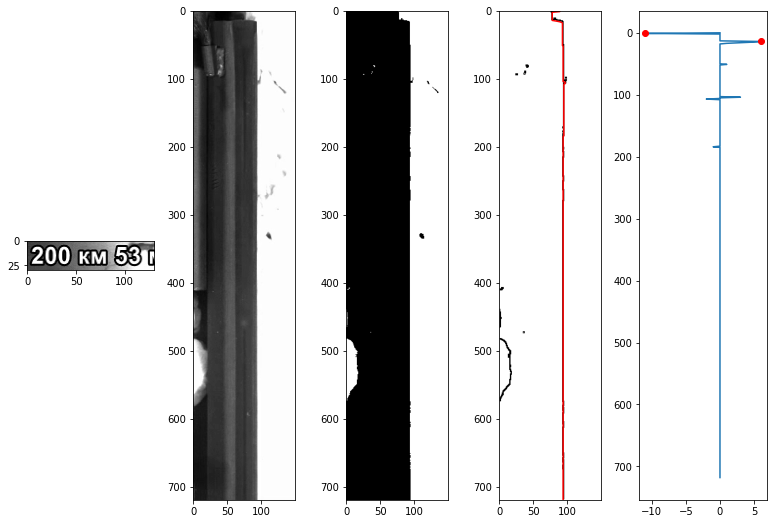

KeyboardInterrupt: 

In [27]:
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

counter_success = 0
counter_all = 0

cap = cv2.VideoCapture(DATA)

while cap.isOpened():

    counter_all += 1

    ret, rgb_frame = cap.read()
    if not ret:
        print("Видео закончилось. Выходим....")
        break

    border = None
    for i in range(2):
        gray_image, binary_image, binary_image_intermediate = image_processing(
            rgb_frame)
        if border is not None:
            middle = int(np.mean(border))
            shift_border = min(middle+10, binary_image.shape[1]-1)
            binary_image[:, shift_border:] = 1

            shift_border = min(middle+2, binary_image.shape[1]-1)
            binary_image[0, shift_border:] = 1

        start_column = find_first_column(binary_image)
        row = 0
        column = start_column
        border = [column, ]
        while row < binary_image.shape[0]-1:
            row += 1
            column = find_next_column(binary_image, row, column, border)
            if column is not None:
                border.append(column)
            else:
                border.append(border[-1])
        border = np.array(border)

    delta_border = np.diff(border)
    min_a = np.min(delta_border)
    min_index = np.argmin(delta_border)
    next_part = delta_border[min_index +
        1: min(min_index + GAP_LIMIT, len(delta_border))]
    max_a = np.max(next_part)
    max_index = np.argmax(next_part) + min_index+1
    thresh = max_a - min_a

    if ((thresh > THRESH_LIMIT)
            and (abs(min_a) > THRESH_LIMIT_ONE_SIDE)
            and (max_a > THRESH_LIMIT_ONE_SIDE)
            and (max_index > min_index)):
        gap = max_index - min_index
        if gap < GAP_LIMIT:
            counter_success += 1
            clear_output()
            print(f"{counter_success}; cadr: {counter_all}; gap: {gap}")
            plot(rgb_frame, gray_image, binary_image_intermediate, binary_image, border, delta_border, min_a,
                     max_a, min_index, max_index)
            cv2.imwrite(os.path.join(OUTPUT_FOLDER, f"{counter_all}.jpg"), rgb_frame)